In [1]:
import sys
import re
import os
import numpy as np
import shutil
import matplotlib.pyplot as plt
import pandas as pd
import pandas.testing as pdt
import warnings
from scipy.optimize import approx_fprime
import xarray as xr
try:
    from pandas.core.common import SettingWithCopyWarning
except:
    from pandas.errors import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
sys.path.insert(0,os.path.join(os.getcwd(), '../', 'src'))
from ciceroscm import CICEROSCM
from ciceroscm.input_handler import read_inputfile,read_components,read_natural_emissions
from scipy.optimize import minimize, approx_fprime


/tmp/ipykernel_2536855/3022117654.py:7: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
def to_df(cscm):
    """Convert the results of a CICEROSCM object to a DataFrame"""
    out=pd.concat([pd.DataFrame(v) for k, v in cscm.results.items()], axis = 1, keys = list(cscm.results.keys()))
    return out


def check_hfc(species):
    """Check if the species is an HFC and remove the hyphen"""
    if "HFC-" in species:
        sp_in = species.replace("-", "")
    else:
        sp_in = species
    return sp_in

def zero_mf(species):
    """Create a DataFrame of zeros for a given species"""
    sp_in = check_hfc(species)
    dfc = pd.DataFrame(index=emi_input.index, columns=[sp_in], data=0)
    dfc.index.name = "Component"
    return dfc


def finite_difference_second_derivative(f, x, epsilon=1e-8):
    return (f(x + epsilon) - 2 * f(x) + f(x - epsilon)) / epsilon**2


def run_ciceroscm(gaspam_in, emi_input_in, df_ssp2_conc_in, conc_run=False, taupert=0.0, o3pert=0, Faci=0.):
    # NBVAL_IGNORE_OUTPUT
    cscm_dir=CICEROSCM({
                "gaspam_data": gaspam_in,
                "emstart": 1750,  
                "conc_run":conc_run,
                "nystart": 1750,
                "nyend": 2019,
                "concentrations_data": df_ssp2_conc_in,
                "emissions_data": emi_input_in,
                "nat_ch4_data": df_nat_ch4,
                "nat_n2o_data": df_nat_n2o,
                "idtm":24,
            }, taupert=taupert, o3pert=o3pert, Faci=Faci)

    # NBVAL_IGNORE_OUTPUT
    cscm_dir._run({
                "results_as_dict":True
            })
    df_temp = to_df(cscm_dir)
    return df_temp

test_data_dir = "/user/home/lw13938/work/ciceroscm/tests/test-data/"

# Read gas parameters
# gaspam =read_components(test_data_dir + '/gases_v1RCMIP.txt')
gaspam = read_components("/user/home/lw13938/work/ciceroscm/inputfiles/gases_WMO2022.txt")
df_nat_ch4 =read_natural_emissions(test_data_dir + '/natemis_ch4.txt','CH4')
df_nat_n2o =read_natural_emissions(test_data_dir + '/natemis_n2o.txt','N2O')

df_ssp2_conc =read_inputfile('/user/home/lw13938/work/ciceroscm/inputfiles/AGAGE_conc.txt')
# emi_input =read_inputfile(test_data_dir + '/ssp245_em_RCMIP.txt')
# emi_input.rename(columns={"CO2": "CO2_FF", "CO2.1": "CO2_AFOLU"}, inplace=True)
# emi_input.rename(columns={"CO2": "CO2_FF", "CO2.1": "CO2_AFOLU"}, inplace=True)
emi_input = read_inputfile('/user/home/lw13938/work/ciceroscm/inputfiles/AGAGE_em.txt')

/user/work/lw13938/ciceroscm/src/ciceroscm/input_handler.py:39: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_gas = pd.read_csv(filename, delim_whitespace=True, index_col=0)
/user/work/lw13938/ciceroscm/src/ciceroscm/input_handler.py:98: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_input = pd.read_csv(
/user/work/lw13938/ciceroscm/src/ciceroscm/input_handler.py:98: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_input = pd.read_csv(


We want the ERF change to methane due to CFCs+HCFCs+HFCs to be -0.051 W/m2.
Need to zero all other ODSs to do this. \\

BUT, it may be that AR6 Ch6 SM is calling it "CFCs, HCFCs and HFCs" when it's actually all halocarbons.

Run with no lifetime adjustment, then run again with a lifetime adjustment to CH4 to optimise to value.

In [3]:
groups = {
          "Solvents": ["CCl4", "CH3CCl3"],
          "PFCs":["CF4", "C2F6","C6F14"],
          "Other":["SF6"],
          "Halons": ["H-1301", "H-2402", "H-1211"]
          }

emi_input_in = emi_input.copy()
df_ssp2_conc_in = df_ssp2_conc.copy()
# for group in groups:
#     for sp in groups[group]:
#         sp_in = check_hfc(sp)
#         df_ssp2_conc_in[sp_in].values[:] = 0
#         emi_input_in[sp_in].values[:] = 0
# emi_input_in = emi_input.copy()
# df_ssp2_conc_in = df_ssp2_conc.copy()



First optimise strat O3 adjustment

O3 perturbation:  [-14.27295713] +/- 4.840663552754036


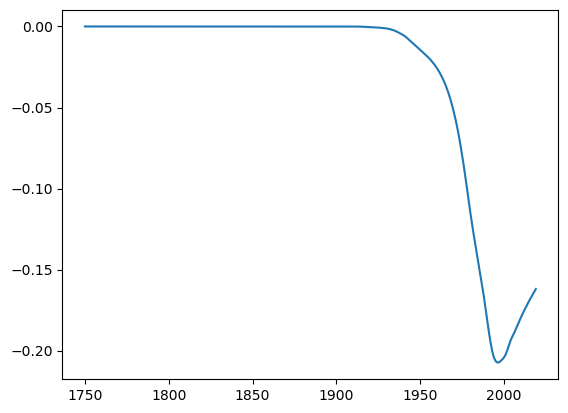

In [4]:
def min_func(x):
    df_out = run_ciceroscm(gaspam, emi_input_in, df_ssp2_conc_in, conc_run=False, o3pert=x)
    mod = df_out["forcing"]['STRAT_O3'].dropna().values[-1]
    return np.sum((mod + 0.162)**2) / 0.0777**2

x0 = np.array([1e-4])
res = minimize(min_func, x0, method='BFGS')#, options={'xatol': 1e-8, 'disp': True})
df_out = run_ciceroscm(gaspam, emi_input_in, df_ssp2_conc_in, conc_run=False, o3pert=res.x)
df_out["forcing"]["STRAT_O3"].dropna().plot()
o3pert = res.x
o3pert_sd = np.sqrt(1/finite_difference_second_derivative(min_func, o3pert, epsilon=1e-8))

print("O3 perturbation: ", o3pert, "+/-", o3pert_sd)


Then optimise the change to methane lifetime

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 15
         Function evaluations: 30
CH4_lifetime perturbation:  [5.29101563e-05] +/- 2.546983126690179e-05


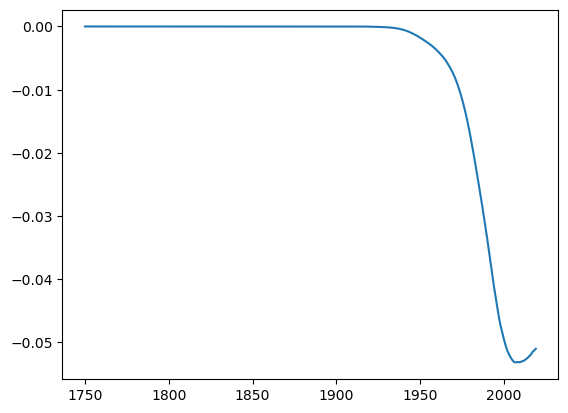

In [5]:
df_out0 = run_ciceroscm(gaspam, emi_input_in, df_ssp2_conc_in, conc_run=False, o3pert=o3pert)
y = df_out0["forcing"]["CH4"].dropna().values[-1]

def min_func(x):
    df_out = run_ciceroscm(gaspam, emi_input_in, df_ssp2_conc_in, conc_run=False, taupert=x)
    mod = df_out["forcing"]["CH4"].dropna().values[-1]
    return np.sum(((mod - y) + 0.051)**2) / 0.0326**2

x0 = np.array([1e-4])
res = minimize(min_func, x0, method='nelder-mead', options={'xatol': 1e-8, 'disp': True})
df_out = run_ciceroscm(gaspam, emi_input_in, df_ssp2_conc_in, conc_run=False, o3pert = o3pert, taupert=res.x)
(df_out["forcing"]["CH4"].dropna() - df_out0["forcing"]["CH4"].dropna()).plot()
taupert = res.x

taupert_sd = np.sqrt(1/finite_difference_second_derivative(min_func, taupert, epsilon=1e-8))

print("CH4_lifetime perturbation: ", taupert, "+/-", taupert_sd)

Now we want to adjust the ERFaci (aerosol-cloud forcing). This is mainly due to increases in tropospheric ozone and OH, but perhaps just make it a function of EESC again. \\
CICERO-SCM just makes ERFaci a linear function of SO2 emissions. Simply adjust this linear factor as an additive function of EESC to reach 2019 IPCC value. 

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 17
         Function evaluations: 34
Faci perturbation:  [2.1484375e-06] +/- 4.435976467218125e-05


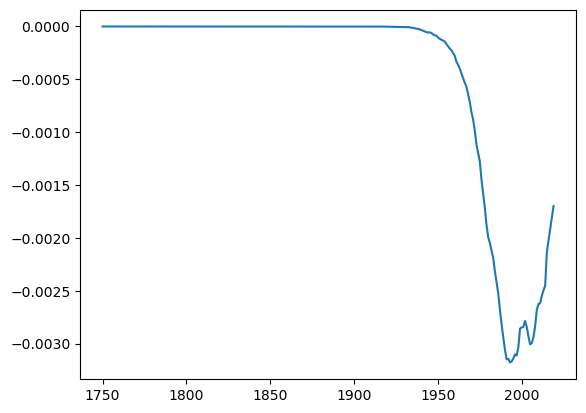

In [6]:
df_out0 = run_ciceroscm(gaspam, emi_input_in, df_ssp2_conc_in, conc_run=False, o3pert=o3pert, taupert=taupert)
y = df_out0["forcing"]['SO4_IND'].dropna().values[-1]

def min_func(x):
    df_out = run_ciceroscm(gaspam, emi_input_in, df_ssp2_conc_in, conc_run=False, o3pert=o3pert, taupert=taupert, Faci=x)
    mod = df_out["forcing"]['SO4_IND'].dropna().values[-1]
    return np.sum(((mod - y) + 0.0017)**2) / 0.0496**2

x0 = np.array([1e-4])
res = minimize(min_func, x0, method='nelder-mead', options={'xatol': 1e-8, 'disp': True})
df_out = run_ciceroscm(gaspam, emi_input_in, df_ssp2_conc_in, conc_run=False, o3pert=o3pert, taupert=taupert, Faci=res.x)
(df_out["forcing"]['SO4_IND'].dropna() - df_out0["forcing"]['SO4_IND'].dropna()).plot()
Faci = res.x

Faci_sd = np.sqrt(1/finite_difference_second_derivative(min_func, Faci, epsilon=1e-8))

print("Faci perturbation: ", Faci, "+/-", Faci_sd)

Quick look at the impacts of all ODSs

In [7]:
o3pert = -14.273
taupert = 5.291e-05
Faci = 2.148e-06

groups = {"all":[],
          "CFCs": ["CFC-11", "CFC-12", "CFC-113", "CFC-114", "CFC-115","CFC-13"],
          "HCFCs": ["HCFC-22", "HCFC-141b", "HCFC-142b", "HCFC-124", "HCFC-133a", "HCFC-123"],
          "HFCs": ["HFC-23", "HFC-32", "HFC-134a", "HFC-143a", "HFC-125",
                   "HFC-152a", "HFC-4310mee", "HFC-227ea", "HFC-365mfc",
                   "HFC-236fa", "HFC-245fa"], 
          "Solvents": ["CCl4", "CH3CCl3"],
          "PFCs":["CF4", "C2F6", "C3F8", "C4F8", "C4F10","C6F14"],
          "Other":["SF6", "NF3","SO2F2"],
          "Halons": ["H-1301", "H-2402", "H-1211", "CH3Br"]}

# csmsp = [item for sublist in groups.values() for item in sublist]
csmsp = groups["CFCs"]+groups["HCFCs"]+groups["Solvents"]+groups["Halons"]#+groups["PFCs"]+groups["Other"]+groups["HFCs"]
df_ssp2_conc0 = df_ssp2_conc.copy()
emi_input0 = emi_input.copy()
for sp in csmsp:
    sp_in = check_hfc(sp)
    if sp == "CH3Br":
        df_ssp2_conc0[sp_in].values[:] = df_ssp2_conc[sp_in].values[0]
        emi_input0[sp_in].values[:] = emi_input[sp_in].values[0]
    else:
        df_ssp2_conc0[sp_in].values[:] = 0.
        emi_input0[sp_in].values[:] = 0.
df_out0 = run_ciceroscm(gaspam, emi_input0, df_ssp2_conc0, conc_run=False, o3pert=o3pert, taupert=taupert, Faci=Faci)
df_out = run_ciceroscm(gaspam, emi_input, df_ssp2_conc, conc_run=False, o3pert=o3pert, taupert=taupert, Faci=Faci)
df_out00 = run_ciceroscm(gaspam, emi_input, df_ssp2_conc, conc_run=False)

(1920.0, 2032.45)

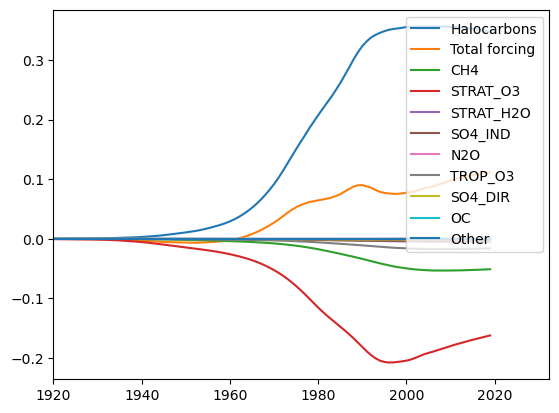

In [8]:
tot_halocarbon = np.zeros_like(df_out["forcing"]["Total_forcing"].dropna())
for sp in csmsp:
    sp_in = check_hfc(sp)
    tot_halocarbon = tot_halocarbon + df_out["forcing"][sp_in].dropna() 
plt.plot(tot_halocarbon, label="Halocarbons")
(df_out["forcing"]["Total_forcing"].dropna()-df_out0["forcing"]["Total_forcing"].dropna()).plot(label="Total forcing")
other = tot_halocarbon-(df_out["forcing"]["Total_forcing"].dropna()-df_out0["forcing"]["Total_forcing"].dropna()).copy()
for label in ["CH4", "STRAT_O3", "STRAT_H2O", "SO4_IND", "N2O", "TROP_O3", "SO4_DIR", "OC"]:
    (df_out["forcing"][label].dropna()-df_out0["forcing"][label].dropna()).plot(label=label)
    other = other + (df_out["forcing"][label].dropna()-df_out0["forcing"][label].dropna())
plt.plot(other, label="Other")


plt.legend()
plt.xlim(1920,None)


In [10]:
weights = np.array([2.51540874e-01, 2.85588337e-01, 1.83647911e-01, 1.09745490e-01,
       6.53733900e-02, 3.93816364e-02, 2.40508141e-02, 1.48813664e-02,
       9.31632867e-03, 5.89277991e-03, 3.76106432e-03, 2.41954343e-03,
       1.56739065e-03, 1.02163109e-03, 6.69558679e-04, 4.40970373e-04,
       2.91703198e-04, 1.93730846e-04, 1.29128440e-04, 8.63517467e-05])[::-1]

def get_ncl(species, ebr=60):
    """Get the number of ECl per molecule"""
    if species == "PCE":
        species = "C2Cl4"
    if "CFC-" in species:
        num = species.split("-")[-1]
        if len(num) > 2:
            a = num[0]
            b = num[1]
            c = num[2]
        else:
            a = str(0)
            b = num[0]
            c = num[1]
        def_ = str(90 + int(a + b + c))
        ncl = 2*int(def_[0]) + 2 - int(def_[1]) - int(def_[2]) 
    elif "H-" in species:
        num = species.split("-")[-1]
        ncl = int(num[-1])*ebr + int(num[-2])
    elif "Cl" in species:
        cl = species.split("Cl")[-1]
        if cl == "":
            ncl = 1
        else:
            ncl = int(cl[0])
    elif "Br" in species:
        br = species.split("Br")[-1]
        if br == "":
            ncl = ebr
        else:
            ncl = int(br[0])*ebr
    else: 
        ncl = 0
    return ncl

EESC_dict_frf_ml_E19 = {
    'CFC-11': 0.47,
    'CFC-12': 0.24,
    'CFC-113': 0.30,
    'CFC-114': 0.13,
    'CFC-115': 0.07,
    'CCl4': 0.56,
    'CH3CCl3': 0.61,
    'HCFC-22': 0.15,
    'HCFC-141b': 0.34,
    'HCFC-142b': 0.17,
    'HCFC-123':0.66,
    'H-1211': 0.65,
    'H-1202': 0.67,
    'H-1301': 0.32,
    'H-2402': 0.66,
    'CH3Br': 0.6,
    'CH3Cl': 0.44,
    'CFC-112': 0.3,
    'CFC-113a': 0.29
}

# Try Newman approach with approx AoA distribution
df_conc = df_out["concentrations"].dropna()
EESC_newman = pd.DataFrame(0, index=df_conc.index, columns=df_conc.columns)
for sp in df_conc.keys():
    if "CFC" in sp or "Cl" in sp or "Br" in sp or "H-" in sp:
        for yr in df_conc.index[20:]:
            EESC_newman.loc[yr, sp] = np.sum(df_conc.loc[(yr-20):(yr-1),sp].values*weights) \
                                    *EESC_dict_frf_ml_E19[sp]*get_ncl(sp)

eesc_newman = (EESC_newman.sum(axis=1)-EESC_newman.loc[1750].sum()).loc['1920':'2014']#.values

/tmp/ipykernel_1711655/2267248087.py:70: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.00081290278755374' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  EESC_newman.loc[yr, sp] = np.sum(df_conc.loc[(yr-20):(yr-1),sp].values*weights) \
/tmp/ipykernel_1711655/2267248087.py:70: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.0011102075385682577' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  EESC_newman.loc[yr, sp] = np.sum(df_conc.loc[(yr-20):(yr-1),sp].values*weights) \
/tmp/ipykernel_1711655/2267248087.py:70: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.00014085261378719282' has dtype incompatible with int64, please explicitly cast to a compatible dtype 

<Axes: >

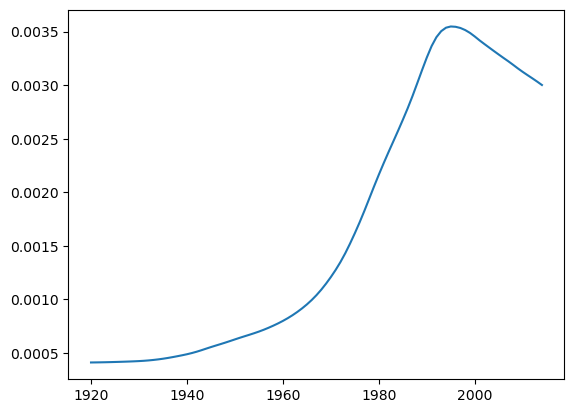

In [11]:
(eesc_newman*Faci).plot()

In [13]:
(eesc_newman*Faci)

1920    0.000410
1921    0.000410
1922    0.000411
1923    0.000412
1924    0.000413
          ...   
2010    0.003124
2011    0.003094
2012    0.003064
2013    0.003033
2014    0.003001
Length: 95, dtype: float64